In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm


import multiprocessing as mp

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [ ]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'
num_workers = 24
num_gpus = 7
bs = 32 * num_gpus 

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IM_FOLDER = V5_IMAGE_DIR + "/trn_full_rgb/"
FMT_VALTEST_IM_FOLDER = V5_IMAGE_DIR + "/test_full_rgb/"

FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
# FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
# FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MASK_STORE = V5_IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = V5_IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_IMMEAN = V5_IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

## Preprocessing

In [5]:
# datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
# !python code/v5_im-full_rgb.py preproc_train {datapaths[1]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[3]}

In [7]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_train {datapaths[2]}

In [8]:
# for d in datapaths: print(d, end=' ')

In [9]:
# !parallel python code/v5_im-full_rgb.py preproc_train {} ::: data/train/AOI_2_Vegas_Train data/train/AOI_3_Paris_Train data/train/AOI_4_Shanghai_Train data/train/AOI_5_Khartoum_Train

In [10]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [1]:
from concurrent.futures import ThreadPoolExecutor

In [7]:
def print_shape(a):
    print(a.shape)
    
e = ThreadPoolExecutor(max_workers=2)
t = np.zeros((3,2,3))
e.map(print_shape, t)

(2, 3)
(2, 3)


<generator object Executor.map.<locals>.result_iterator at 0x7f74c023fe08>

(2, 3)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def get_data(area_id, is_test):
    prefix = area_id_to_prefix(area_id)
    fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) if is_test else FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
    df_train = pd.read_csv(fn_train)
    
    fn_im = FMT_VALTEST_MASK_STORE.format(prefix) if is_test else FMT_VALTRAIN_MASK_STORE.format(prefix)
    y_val = np.zeros((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 1))
    with tb.open_file(fn_im, 'r') as f:
        for i, image_id in tqdm.tqdm(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0]):
            fn = '/' + image_id
            y_val[i] = np.array(f.get_node(fn))[..., None]
            
    fn_im = FMT_VALTEST_IM_FOLDER if is_test else FMT_VALTRAIN_IM_FOLDER
    X_val = np.zeros((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3))
    for i, image_id in tqdm.tqdm(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0]):
        X_val[i] = plt.imread(fn_im + image_id + '.png')[...,:3]
#             print(im.shape)
#         im = np.moveaxis(im, -1, 0)

    X_val, y_val = X_val.astype('float'), y_val.astype('float')
    return X_val, y_val

In [13]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_data(area_id, False)
#     print(trn_x.shape, trn_y.shape)
#     trn_x = np.moveaxis(trn_x, 1, -1).astype('float') # --> [bs, h, w, ch]
#     trn_y = np.moveaxis(trn_y, 1, -1).astype('float')

#     print(trn_x.shape, trn_y.shape)
    trn_y = np.broadcast_to(trn_y, [trn_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])

    val_x, val_y = get_data(area_id, True)
#     val_x = val_x[:,:3]
#     val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]
#     val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, [val_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])
               
    return (trn_x,trn_y), (val_x,val_y)


In [14]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, is_trn, y, transform):
        # input: ch x w x h
        global trn_x, trn_y, val_x, val_y
#         if is_trn:
#             self.x = trn_x; self.y = trn_y
#         else:
#             self.x = val_x; self.y = val_y
        self.is_trn = is_trn
#         self.num_groups = len(x)
        self.sz = trn_x[0].shape[1] if self.is_trn else val_x[0].shape[1]
#         self.ns = np.array([o.shape[0] for o in x])
#         self.cum_ns = np.cumsum(self.ns * num_slice)
        super().__init__(transform)

        
    def get_im(self, i, is_y):
#         idx_file, idx_im = self.get_file_idx(i)
        if is_y:
            im = trn_y[i//num_slice] if self.is_trn else val_y[i//num_slice]
        else:
            im = trn_x[i//num_slice] if self.is_trn else val_x[i//num_slice]
#         slice_pos = idx_im % num_slice
#         a = np.sqrt(num_slice)
#         cut_i = slice_pos // a
#         cut_j = slice_pos % a
#         stride = (self.sz - sz) // a
#         cut_x = int(cut_j * stride)
#         cut_y = int(cut_i * stride)
        slice_pos = i % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
            
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
        
#     def get_file_idx(self, i):
#         idx_file = np.argmax(i + 1 <= self.cum_ns)
#         if idx_file == 0:
#             idx_im = i
#         else:
#             idx_im = i - self.cum_ns[idx_file - 1]
#         return idx_file, idx_im
    
    def get_n(self): return trn_x.shape[0] * num_slice if self.is_trn else val_x.shape[0] * num_slice
    
    def get_sz(self): return self.sz
        
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [15]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [16]:
def sep_iou(y_pred, y_true, thresh=0.5):
    return np.array([jaccard_coef(p, t) for (p, t) in zip(y_pred, y_true)])
    
def jaccard_coef(y_pred, y_true, thresh=0.5):
    smooth = 1e-12
    y_pred = T(y_pred > thresh).type(torch.FloatTensor)
    y_true = T(y_true > thresh).type(torch.FloatTensor)
    intersection = y_true * y_pred
    sum_ = torch.sum(y_true) + torch.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return torch.mean(jac)

from concurrent.futures import ThreadPoolExecutor
def jaccard_coef_parallel(y_pred, y_true, thresh=0.5):
    if num_workers == 0:
        return jaccard_coef(y_pred, y_true, thresh=0.5)
    
    with ThreadPoolExecutor(max_workers=self.num_workers) as e:
        

# def jaccard_coef_int(y_true, y_pred):
#     smooth = 1e-12
#     y_true = torch.round(y_true)
#     y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
#     intersection = torch.sum(y_true * y_pred_pos)
#     sum_ = torch.sum(y_true + y_pred_pos)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return jac.mean()

In [17]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    
    mean = [np.mean(im_mean[i]) for i in range(3)]
    std = [np.std(im_mean[i]) for i in range(3)]
    return np.stack([np.array(mean), np.array(std)])

def get_md_model(datapaths, trn, val, device_ids=range(num_gpus)):
#     (trn_x, trn_y), (val_x, val_y) = trn, val
    aug_tfms = transforms_top_down
    for o in aug_tfms: o.tfm_y = TfmType.CLASS
        
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    stats = np.mean([get_rgb_mean_stat(area_id) for area_id in area_ids], axis=0)
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    datasets = ImageData.get_ds(ArraysSingleDataset, (True, True), (False, False), tfms)
    md = ImageData('data', datasets, bs, num_workers=num_workers, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [18]:
(trn_x,trn_y), (val_x,val_y) = (None, None), (None, None)
last_dataset_idx = None
def learner_on_dataset(dataset_idx):
    global trn_x, trn_y, val_x, val_y
    global last_dataset_idx
    
    last_dataset_idx = dataset_idx
    (trn_x,trn_y), (val_x,val_y) = get_dataset(datapaths[dataset_idx])
    md, model, denorm = get_md_model([datapaths[dataset_idx]], (trn_x,trn_y), (val_x,val_y))
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=expanded_loss
    learn.metrics=[jaccard_coef]
    return learn, denorm

def load_backup_learn():
    global trn_x, trn_y, val_x, val_y
    global last_dataset_idx
    
    md, model, denorm = get_md_model([datapaths[last_dataset_idx]], (trn_x,trn_y), (val_x,val_y))
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=expanded_loss
    learn.metrics=[jaccard_coef]
    return learn

In [19]:
def train_and_plot(idx, fn, lrs, epoch=1, wds=None, cycle_len=8, **kwargs):
    lrs = np.array([lr/3,lr])
    kwargs['cycle_len'] = cycle_len
    learn.fit(lrs, epoch, wds, **kwargs)
    plt.subplots(1, 2, figsize=(10, 5))
    plt.tight_layout()
    plt.subplot(121)
    plt.plot(learn.sched.iterations, learn.sched.losses)
    plt.subplot(122)
    plt.plot(learn.sched.iterations, learn.sched.lrs)
    learn.save(fn + '_' + str(idx))
    
def after_train_plot():
    plt.subplots(1, 2, figsize=(10, 5))
    plt.tight_layout()
    plt.subplot(121)
    plt.plot(learn.sched.iterations, learn.sched.losses)
    plt.subplot(122)
    plt.plot(learn.sched.iterations, learn.sched.lrs)
    
def bool_pred(pred, thresh=0.5):
    return to_np(pred > thresh)

In [20]:
def plot_worse(tta, shift=0, n_ims=9, is_best=False):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    ious = sep_iou(tta_exp, tta[1])
    lowest_iou_idx = np.argsort(ious)
    if is_best:
        lowest_iou_idx = np.flip(lowest_iou_idx, 0)
    
    col = 4
    plt.subplots(n_ims, 4, figsize=(15,30))
    
    for i in range(n_ims):
        x, _ = learn.data.fix_dl.get_batch([lowest_iou_idx[i + shift]])
        plt.subplot(n_ims, col, i * col + 1)
        plt.xlabel('rgb')
        plt.imshow(denorm(x)[0])

        plt.subplot(n_ims, col, i * col + 2)
        plt.imshow(tta_exp[lowest_iou_idx[i + shift]])
        plt.xlabel('Prediction: iou = ' + str(ious[lowest_iou_idx[i + shift]]))
        
        plt.subplot(n_ims, col, i * col + 3)
        plt.imshow(bool_pred(tta_exp[lowest_iou_idx[i + shift]], 0.5))
        plt.xlabel('bool_pred')

        plt.subplot(n_ims, col, i * col + 4)
        plt.imshow(tta[1][lowest_iou_idx[i + shift]])
        plt.xlabel('GT')
    plt.tight_layout()

In [21]:
learn, denorm = learner_on_dataset(1)
learn.load('autosaved')

100%|██████████| 1156/1156 [00:28<00:00, 40.46it/s]


In [ ]:
learn = load_backup_learn()
learn.load('autosaved')
learn.bn_freeze(False)

In [35]:
!ls data/models

autosaved.h5  tmp.h5	      unfreezed_3.h5  unfreezed_5.h5  unfreezed_7.h5
freezed_1.h5  unfreezed_2.h5  unfreezed_4.h5  unfreezed_6.h5
autosaved.h5  tmp.h5	      unfreezed_3.h5  unfreezed_5.h5  unfreezed_7.h5
freezed_1.h5  unfreezed_2.h5  unfreezed_4.h5  unfreezed_6.h5


In [22]:
learn.load('autosaved')

In [ ]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/124 [00:00<?, ?it/s]

In [22]:
lr = 1e-4
learn.bn_freeze(False)
lrs = np.array([lr/3, lr])
wd = 0.025
wds = [wd/10, wd]

In [ ]:
%%time
train_and_plot(0, 'vegas', epoch=1, lrs=lrs, wds=wds, cycle_len=8, use_clr=(20,8), use_wd_sched=True, best_save_name='autosaved')

[<fastai.sgdr.WeightDecaySchedule object at 0x7f36210f9d68>, <fastai.sgdr.SaveBestModel object at 0x7f36210f9978>]


HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

In [23]:
%%time
train_and_plot(0, 'vegas', epoch=1, lrs=lrs, wds=wds, cycle_len=8, use_clr=None, use_wd_sched=True, best_save_name='autosaved')

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

100%|██████████| 116/116 [03:08<00:00,  1.62s/it, loss=0.595]6748.58285


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [22]:
%%time
tta = learn.TTA()

1276.846482
 75%|███████▌  | 3/4 [03:30<01:10, 70.31s/it]2518.977804
CPU times: user 1h 39min 12s, sys: 2h 3min 8s, total: 3h 42min 21s
Wall time: 5min 36s


In [24]:
%%time
tta = learn.TTA()

                                             CPU times: user 58min 11s, sys: 6min 12s, total: 1h 4min 24s
Wall time: 6min 50s
CPU times: user 58min 11s, sys: 6min 12s, total: 1h 4min 24s
Wall time: 6min 50s


In [25]:
%%time
preds = learn.predict()

CPU times: user 11min 9s, sys: 1min 48s, total: 12min 57s
Wall time: 1min 8s
CPU times: user 11min 9s, sys: 1min 48s, total: 12min 57s
Wall time: 1min 8s


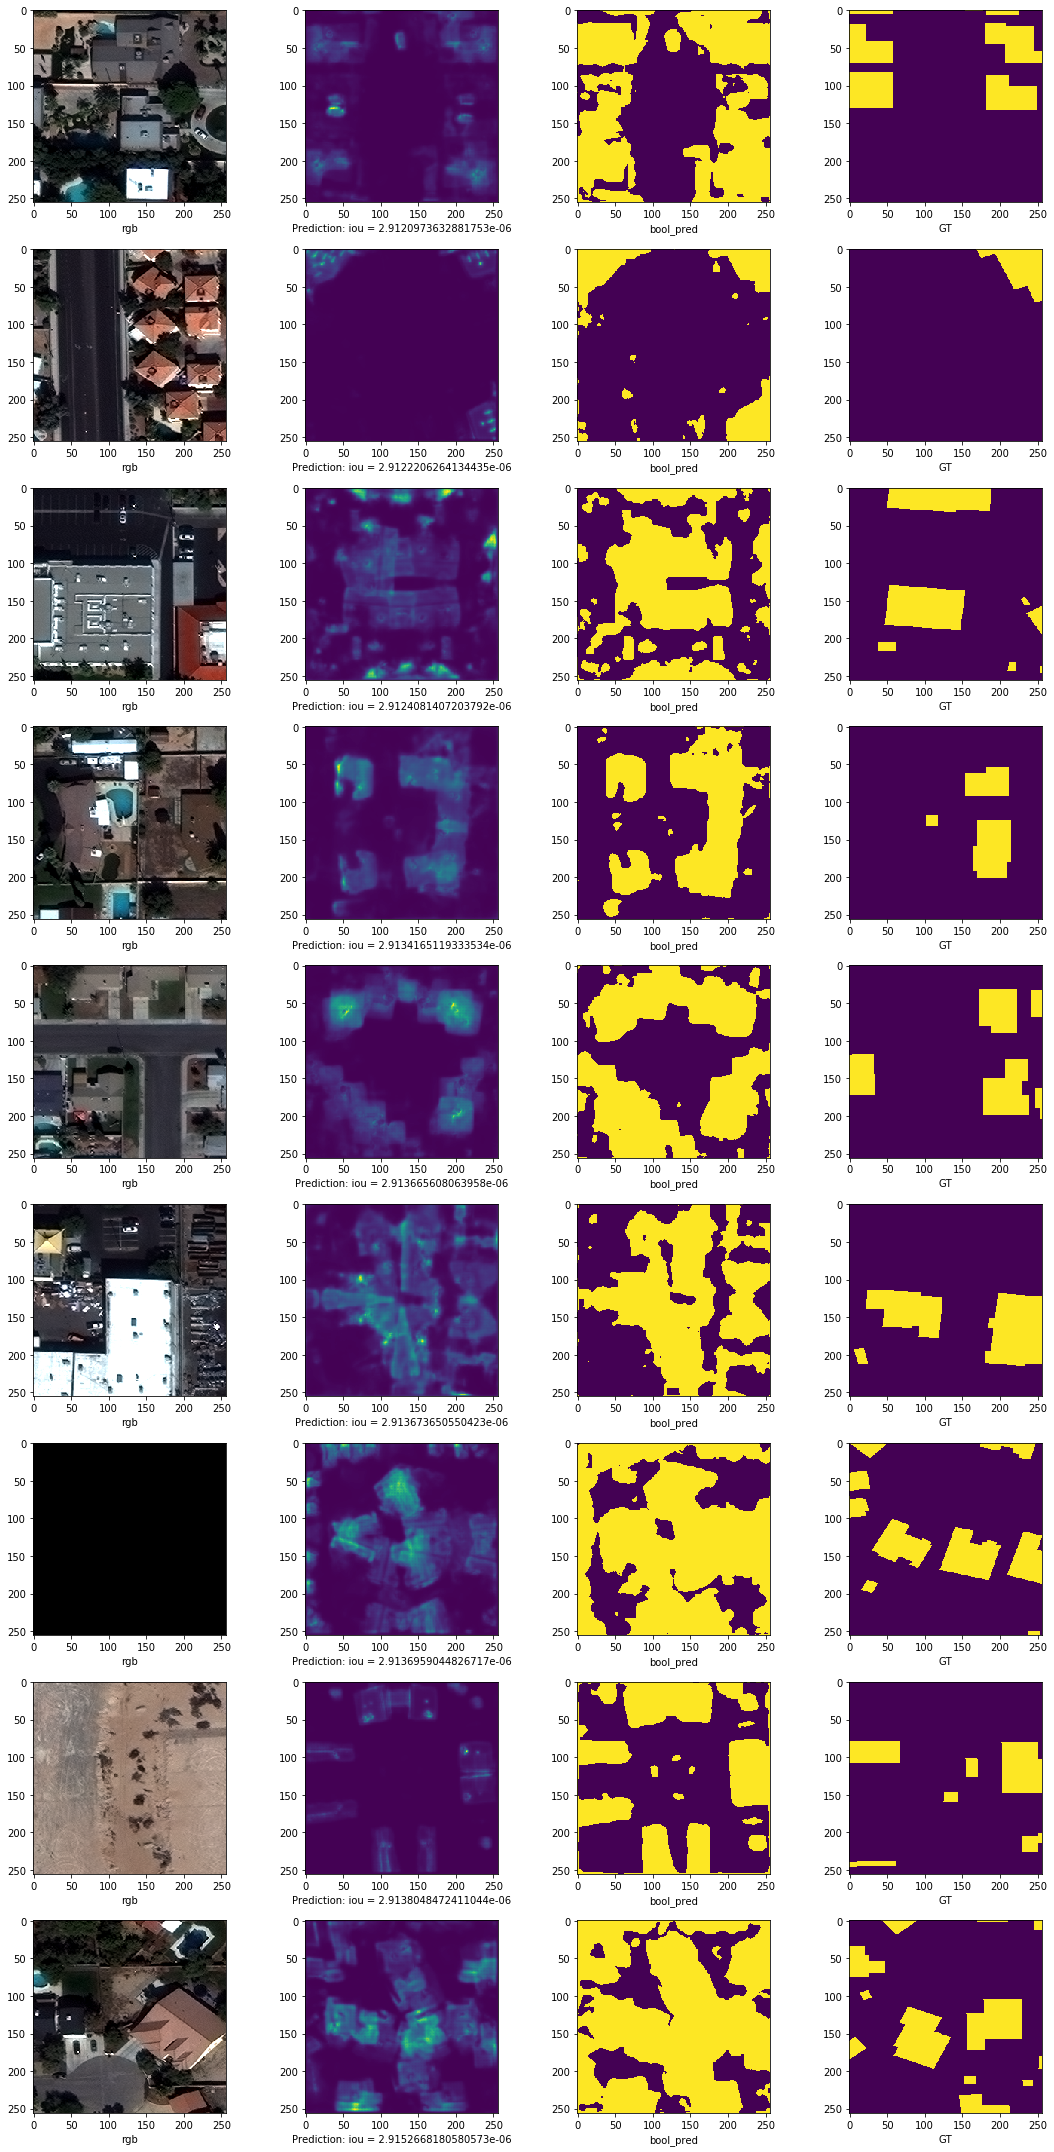

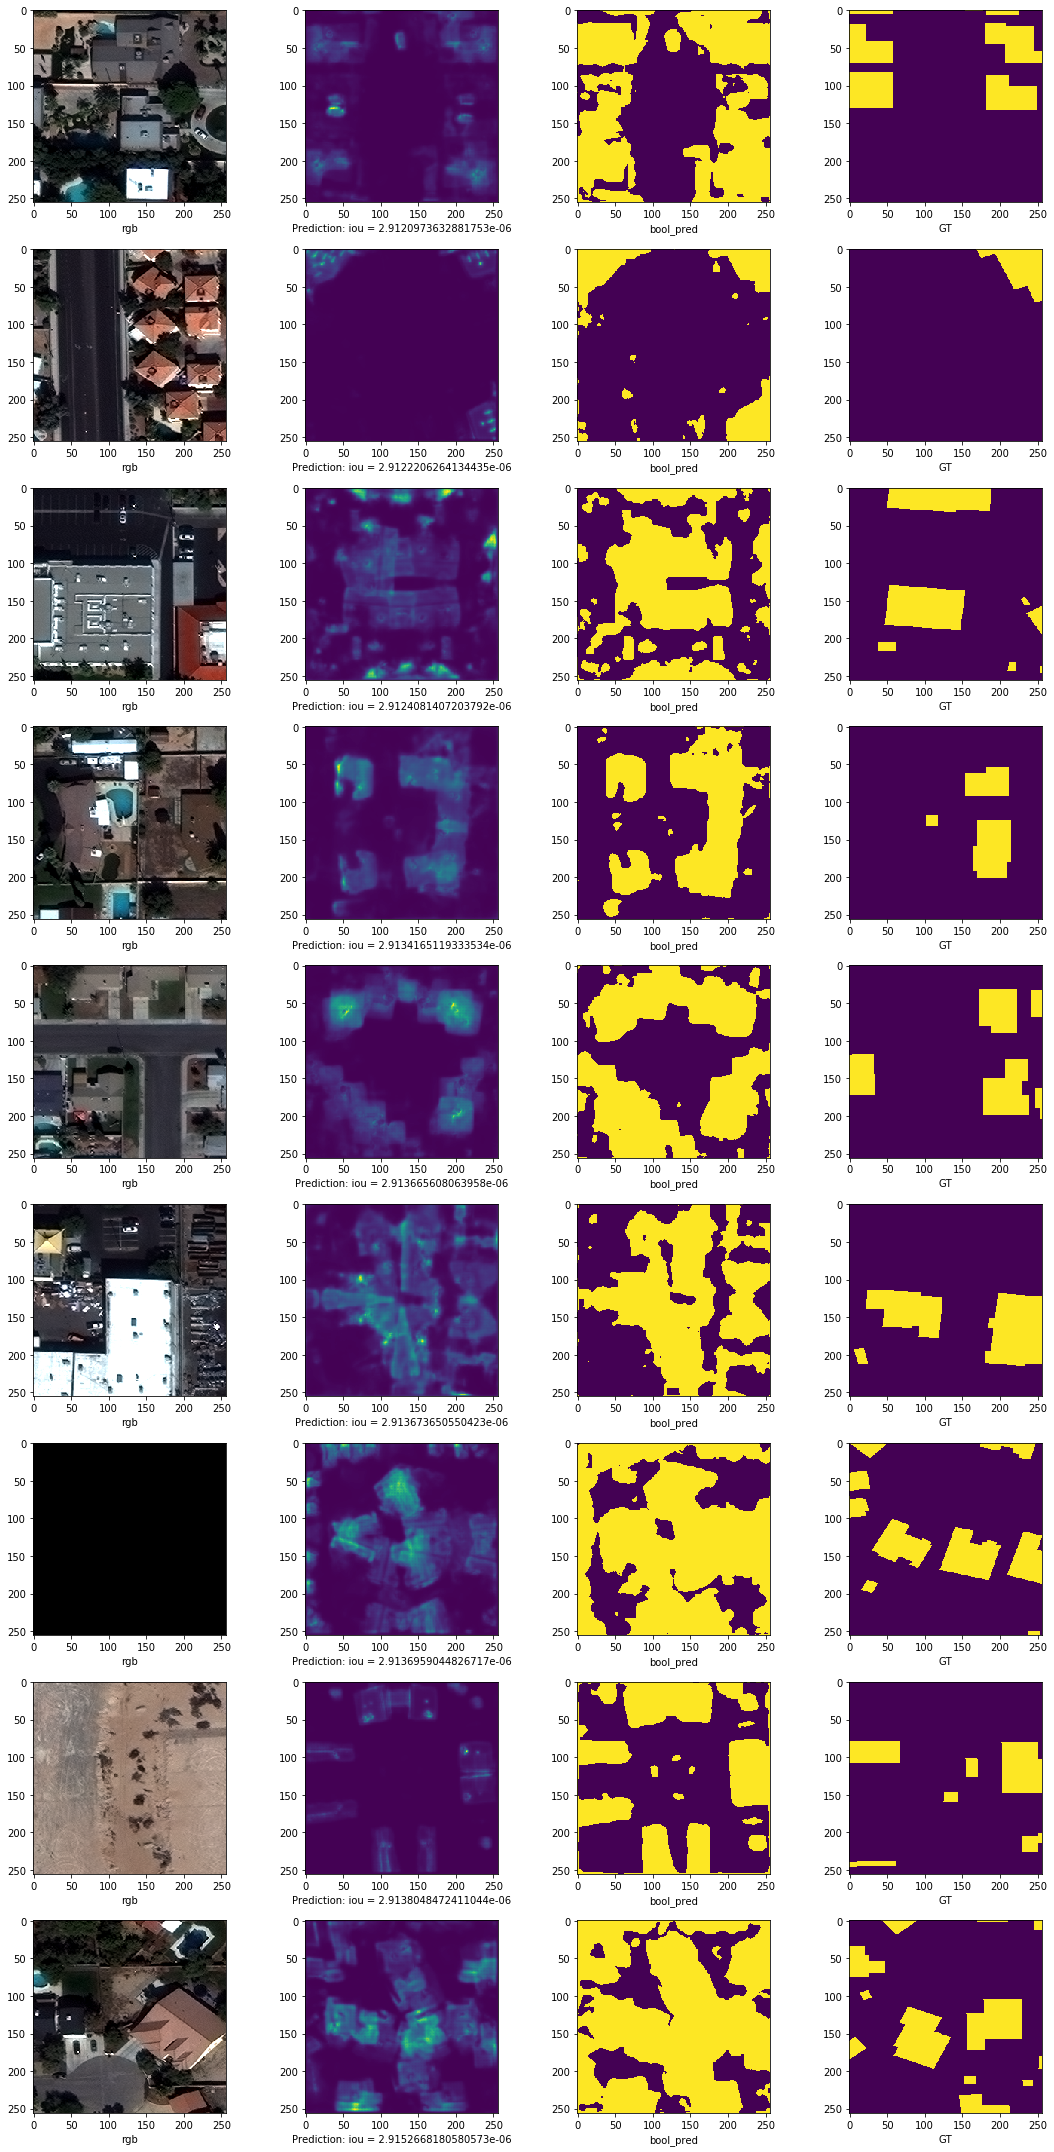

In [26]:
plot_worse(tta, shift=3000, n_ims=9)